In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""


import numpy as np
import tensorflow as tf

from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import WGAN
from gantools.gansystem import GANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

# Parameters

In [3]:
ns = 32 # Resolution of the image
scaling = 16
try_resume = True

# Data handling

Load the data

In [4]:
dataset = data.load.load_maps_dataset(spix=ns, scaling=16, augmentation=True, patch=False)

images shape =  (200, 2304, 2560, 3)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 32, 32, 3)


In [6]:
# Get all the data
X = dataset.get_all_data().flatten()

Display the histogram of the pixel densities after the forward map

min: 0.00784289836883545
max: 0.9961089491844177


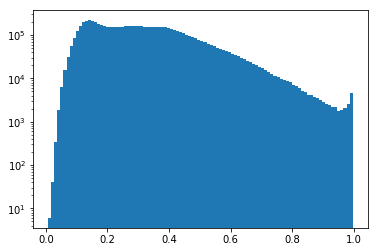

In [7]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [8]:
# to free some memory
del X

Let us plot 16 images

Text(0.5,1,'Real samples')

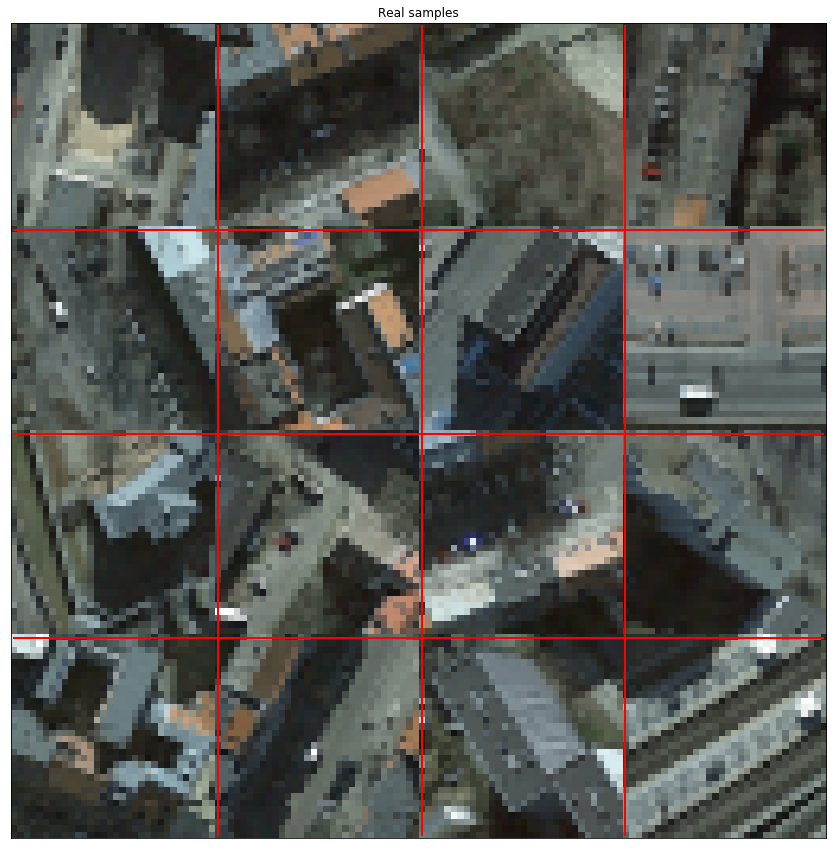

In [9]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16),nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [10]:
time_str = 'maps_scaling{}_test_4'.format(scaling)
global_path = '../saved_results'

name = 'WGAN{}'.format(ns) + '_' + time_str

## Parameters

In [11]:
bn = False

def non_lin(x):
    return (tf.nn.tanh(x) + 1.0)/2.0

md=8

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 1, 1, 1]
params_discriminator['nfilter'] = [md, 4*md, 16*md, 16*md, 8]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn]
params_discriminator['full'] = [512, 256]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = True
params_discriminator['spectral_norm'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 1, 1, 1]
params_generator['latent_dim'] = 256
params_generator['nfilter'] = [64*md, 16*md, 4*md, md, md, 3]
params_generator['shape'] = [[3, 3], [5, 5],[5, 5], [5, 5],[5, 5],[5, 5]]
params_generator['batch_norm'] = [False, False, False, False, False]
params_generator['full'] = [4*4*16]
params_generator['summary'] = True
params_generator['non_lin'] = non_lin
params_generator['data_size'] = 2
params_generator['inception'] = True
params_generator['spectral_norm'] = True

params_optimization = dict()
params_optimization['batch_size'] = 16
params_optimization['epoch'] = 10000
params_optimization['n_critic'] = 2
params_optimization['generator'] = dict()
params_optimization['generator']['optimizer'] = 'adam'
params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['generator']['learning_rate'] = 0.0004
params_optimization['discriminator'] = dict()
params_optimization['discriminator']['optimizer'] = 'adam'
params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['discriminator']['learning_rate'] = 0.0001


# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 3] # Shape of the image
# params['net']['gamma_gp'] = 10 # Gradient penalty
params['net']['upsampling'] = None 

params['optimization'] = params_optimization
params['summary_every'] = 100 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 200

resume, params = utils.test_resume(try_resume, params)


Resume, the training will start from the last iteration!


# Build the model

In [12]:
wgan = GANsystem(WGAN, params)

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     0 Full layer with 256 outputs
         Size of the variables: (?, 256)
     Reshape to (?, 4, 4, 16)
     0 Inception deconv(1x1,3x3,5x5) layer with 512 channels
         Non linearity applied
         Size of the variables: (?, 8, 8, 1536)
     1 Inception deconv(1x1,3x3,5x5) layer with 128 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 384)
     2 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 96)
     3 Inception deconv(1x1,3x3,5x5) layer with 8 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 24)
     4 Inception deconv(1x1,3x3,5x5) layer with 8 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 24)
     5 Inception deconv(1x1,3x3,5x5) layer with 3 channels
         Size of the variables: (?, 32, 32

# Train the model

In [64]:
wgan.train(dataset, resume=resume)

Compute real statistics: descriptives/mean_l2
Compute real statistics: descriptives/var_l2
Compute real statistics: descriptives/min_l2
Compute real statistics: descriptives/max_l2
Compute real statistics: descriptives/kurtosis_l2
Compute real statistics: descriptives/skewness_l2
Compute real statistics: descriptives/median_l2
Erase recursively directory: ../saved_results/WGAN32_maps_scaling16_test_4_summary/
Erase recursively directory: ../saved_results/WGAN32_maps_scaling16_test_4_checkpoints/
Start training
 * Epoch: [ 0] [  50/ 150] Counter:50	( 0.2 min	68.043 examples/sec	0.24 sec/batch)
   Disc batch loss:1.37987614	Disc epoch loss:1.08520526
   Gen batch loss:-0.22878222	Gen epoch loss:0.40665487
 * Epoch: [ 0] [ 100/ 150] Counter:100	( 0.3 min	150.074 examples/sec	0.11 sec/batch)
   Disc batch loss:0.98464948	Disc epoch loss:1.08037437
   Gen batch loss:2.05364513	Gen epoch loss:0.53768021
 * Epoch: [ 0] [ 150/ 150] Counter:150	( 0.5 min	65.375 examples/sec	0.24 sec/batch)
   D

 * Epoch: [13] [  50/ 150] Counter:2000	( 3.9 min	146.453 examples/sec	0.11 sec/batch)
   Disc batch loss:1.54600596	Disc epoch loss:0.34263704
   Gen batch loss:-0.54600590	Gen epoch loss:1.29574264
Model saved!
 * Epoch: [13] [ 100/ 150] Counter:2050	( 4.0 min	118.835 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00716001	Disc epoch loss:0.41311192
   Gen batch loss:1.78580320	Gen epoch loss:1.13584969
 * Epoch: [13] [ 150/ 150] Counter:2100	( 4.1 min	145.911 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.40447490
   Gen batch loss:1.85652089	Gen epoch loss:1.21433081
 * Epoch: [14] [  50/ 150] Counter:2150	( 4.2 min	139.651 examples/sec	0.11 sec/batch)
   Disc batch loss:0.97583055	Disc epoch loss:0.58170021
   Gen batch loss:1.21615863	Gen epoch loss:1.08271182
 * Epoch: [14] [ 100/ 150] Counter:2200	( 4.3 min	147.474 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.51007744
   Gen batch loss:1.18991089	Gen epoch loss:1.

 * Epoch: [26] [ 150/ 150] Counter:4050	( 7.8 min	118.260 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.49537342
   Gen batch loss:2.77119875	Gen epoch loss:1.19206806
 * Epoch: [27] [  50/ 150] Counter:4100	( 7.9 min	146.211 examples/sec	0.11 sec/batch)
   Disc batch loss:0.88460147	Disc epoch loss:0.49367049
   Gen batch loss:1.56805182	Gen epoch loss:1.39326991
 * Epoch: [27] [ 100/ 150] Counter:4150	( 8.0 min	140.969 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.42429034
   Gen batch loss:1.27993727	Gen epoch loss:1.50163777
 * Epoch: [27] [ 150/ 150] Counter:4200	( 8.1 min	145.389 examples/sec	0.11 sec/batch)
   Disc batch loss:0.39016771	Disc epoch loss:0.41572496
   Gen batch loss:3.18391442	Gen epoch loss:1.47430662
 * Epoch: [28] [  50/ 150] Counter:4250	( 8.1 min	142.156 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00887007	Disc epoch loss:0.45043873
   Gen batch loss:1.92950308	Gen epoch loss:1.24097604
 * Ep

 * Epoch: [40] [ 150/ 150] Counter:6150	(11.7 min	142.111 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28900113
   Gen batch loss:1.06961644	Gen epoch loss:1.64236211
 * Epoch: [41] [  50/ 150] Counter:6200	(11.8 min	147.727 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.40898021
   Gen batch loss:1.68686414	Gen epoch loss:1.32966246
 * Epoch: [41] [ 100/ 150] Counter:6250	(11.9 min	142.944 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.42454742
   Gen batch loss:1.22610307	Gen epoch loss:1.33099574
 * Epoch: [41] [ 150/ 150] Counter:6300	(12.0 min	145.705 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00537151	Disc epoch loss:0.40150010
   Gen batch loss:0.99462849	Gen epoch loss:1.36769054
 * Epoch: [42] [  50/ 150] Counter:6350	(12.1 min	140.422 examples/sec	0.11 sec/batch)
   Disc batch loss:0.48592627	Disc epoch loss:0.41240702
   Gen batch loss:4.25154591	Gen epoch loss:1.47089419
 * Ep

 * Epoch: [54] [ 150/ 150] Counter:8250	(15.6 min	140.700 examples/sec	0.11 sec/batch)
   Disc batch loss:0.46924406	Disc epoch loss:0.30452022
   Gen batch loss:0.53075594	Gen epoch loss:1.60067261
 * Epoch: [55] [  50/ 150] Counter:8300	(15.7 min	144.525 examples/sec	0.11 sec/batch)
   Disc batch loss:0.10831976	Disc epoch loss:0.52307540
   Gen batch loss:2.17790914	Gen epoch loss:1.62297056
 * Epoch: [55] [ 100/ 150] Counter:8350	(15.8 min	143.207 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.40875159
   Gen batch loss:2.62902546	Gen epoch loss:1.79243794
 * Epoch: [55] [ 150/ 150] Counter:8400	(15.9 min	150.384 examples/sec	0.11 sec/batch)
   Disc batch loss:0.18115765	Disc epoch loss:0.36715633
   Gen batch loss:2.11207366	Gen epoch loss:1.77622858
 * Epoch: [56] [  50/ 150] Counter:8450	(16.0 min	140.642 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17953101
   Gen batch loss:1.47972322	Gen epoch loss:1.84364037
 * Ep

 * Epoch: [68] [ 100/ 150] Counter:10300	(19.5 min	145.514 examples/sec	0.11 sec/batch)
   Disc batch loss:0.20789492	Disc epoch loss:0.41910511
   Gen batch loss:0.79210508	Gen epoch loss:1.64566529
 * Epoch: [68] [ 150/ 150] Counter:10350	(19.6 min	140.279 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.41694568
   Gen batch loss:1.37964439	Gen epoch loss:1.56693241
 * Epoch: [69] [  50/ 150] Counter:10400	(19.7 min	146.655 examples/sec	0.11 sec/batch)
   Disc batch loss:0.75723696	Disc epoch loss:0.57605621
   Gen batch loss:1.45678759	Gen epoch loss:1.09488064
 * Epoch: [69] [ 100/ 150] Counter:10450	(19.7 min	141.049 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.50876891
   Gen batch loss:2.22450829	Gen epoch loss:1.17740246
 * Epoch: [69] [ 150/ 150] Counter:10500	(19.8 min	147.205 examples/sec	0.11 sec/batch)
   Disc batch loss:0.70149642	Disc epoch loss:0.48935912
   Gen batch loss:0.29850358	Gen epoch loss:1.33026418


 * Epoch: [82] [  50/ 150] Counter:12350	(23.3 min	139.598 examples/sec	0.11 sec/batch)
   Disc batch loss:1.79661083	Disc epoch loss:0.29220007
   Gen batch loss:-0.79661083	Gen epoch loss:1.26585629
 * Epoch: [82] [ 100/ 150] Counter:12400	(23.4 min	146.988 examples/sec	0.11 sec/batch)
   Disc batch loss:0.72863364	Disc epoch loss:0.28172906
   Gen batch loss:0.27136633	Gen epoch loss:1.46474547
 * Epoch: [82] [ 150/ 150] Counter:12450	(23.5 min	141.129 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.31877336
   Gen batch loss:2.15983200	Gen epoch loss:1.46281910
 * Epoch: [83] [  50/ 150] Counter:12500	(23.6 min	142.901 examples/sec	0.11 sec/batch)
   Disc batch loss:0.64752418	Disc epoch loss:0.39201665
   Gen batch loss:2.01411247	Gen epoch loss:1.23527431
 * Epoch: [83] [ 100/ 150] Counter:12550	(23.7 min	140.525 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.36170486
   Gen batch loss:2.01468015	Gen epoch loss:1.28895215

 * Epoch: [95] [ 150/ 150] Counter:14400	(27.2 min	147.543 examples/sec	0.11 sec/batch)
   Disc batch loss:0.17451870	Disc epoch loss:0.40109890
   Gen batch loss:0.82548130	Gen epoch loss:1.26136429
 * Epoch: [96] [  50/ 150] Counter:14450	(27.3 min	141.865 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.40690375
   Gen batch loss:3.34649825	Gen epoch loss:1.36883478
 * Epoch: [96] [ 100/ 150] Counter:14500	(27.3 min	145.687 examples/sec	0.11 sec/batch)
   Disc batch loss:0.49141502	Disc epoch loss:0.37225920
   Gen batch loss:0.50858498	Gen epoch loss:1.44361372
 * Epoch: [96] [ 150/ 150] Counter:14550	(27.4 min	140.058 examples/sec	0.11 sec/batch)
   Disc batch loss:0.64873970	Disc epoch loss:0.35737694
   Gen batch loss:0.35126030	Gen epoch loss:1.52954616
 * Epoch: [97] [  50/ 150] Counter:14600	(27.5 min	147.033 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.52821466
   Gen batch loss:3.63429856	Gen epoch loss:1.27594373


 * Epoch: [109] [ 100/ 150] Counter:16450	(31.0 min	138.897 examples/sec	0.12 sec/batch)
   Disc batch loss:1.06378448	Disc epoch loss:0.28374583
   Gen batch loss:-0.06378452	Gen epoch loss:1.49827857
 * Epoch: [109] [ 150/ 150] Counter:16500	(31.1 min	146.889 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.33592098
   Gen batch loss:1.51929450	Gen epoch loss:1.43399189
 * Epoch: [110] [  50/ 150] Counter:16550	(31.2 min	140.437 examples/sec	0.11 sec/batch)
   Disc batch loss:1.57530415	Disc epoch loss:0.33256035
   Gen batch loss:-0.23038101	Gen epoch loss:1.73782620
 * Epoch: [110] [ 100/ 150] Counter:16600	(31.3 min	149.235 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.35972063
   Gen batch loss:2.09458160	Gen epoch loss:1.73767108
 * Epoch: [110] [ 150/ 150] Counter:16650	(31.4 min	139.622 examples/sec	0.11 sec/batch)
   Disc batch loss:0.83465314	Disc epoch loss:0.31698279
   Gen batch loss:2.34634590	Gen epoch loss:1.68

 * Epoch: [123] [  50/ 150] Counter:18500	(34.8 min	145.176 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20597108
   Gen batch loss:1.47451305	Gen epoch loss:1.73547859
 * Epoch: [123] [ 100/ 150] Counter:18550	(34.9 min	137.936 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17802767
   Gen batch loss:1.43772769	Gen epoch loss:1.75559253
 * Epoch: [123] [ 150/ 150] Counter:18600	(35.0 min	148.713 examples/sec	0.11 sec/batch)
   Disc batch loss:0.15622616	Disc epoch loss:0.20379942
   Gen batch loss:3.18503785	Gen epoch loss:1.76119687
 * Epoch: [124] [  50/ 150] Counter:18650	(35.1 min	142.261 examples/sec	0.11 sec/batch)
   Disc batch loss:0.58111954	Disc epoch loss:0.41857566
   Gen batch loss:1.41088188	Gen epoch loss:1.44116188
 * Epoch: [124] [ 100/ 150] Counter:18700	(35.2 min	148.053 examples/sec	0.11 sec/batch)
   Disc batch loss:1.01315856	Disc epoch loss:0.32345856
   Gen batch loss:-0.01315855	Gen epoch loss:1.665

 * Epoch: [136] [ 150/ 150] Counter:20550	(38.7 min	141.357 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.35844204
   Gen batch loss:1.24000144	Gen epoch loss:1.52017988
 * Epoch: [137] [  50/ 150] Counter:20600	(38.8 min	144.950 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25882298
   Gen batch loss:1.98478317	Gen epoch loss:1.76378749
 * Epoch: [137] [ 100/ 150] Counter:20650	(38.9 min	138.323 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21205711
   Gen batch loss:1.13376379	Gen epoch loss:1.73131151
 * Epoch: [137] [ 150/ 150] Counter:20700	(39.0 min	148.284 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19026273
   Gen batch loss:1.60886359	Gen epoch loss:1.69632726
 * Epoch: [138] [  50/ 150] Counter:20750	(39.1 min	141.142 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27338391
   Gen batch loss:1.99165869	Gen epoch loss:1.6319

 * Epoch: [156] [ 150/ 150] Counter:23550	(44.3 min	139.630 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21228127
   Gen batch loss:1.25770450	Gen epoch loss:1.97114431
 * Epoch: [157] [  50/ 150] Counter:23600	(44.4 min	145.853 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.34327211
   Gen batch loss:2.18704319	Gen epoch loss:1.49106505
 * Epoch: [157] [ 100/ 150] Counter:23650	(44.5 min	141.594 examples/sec	0.11 sec/batch)
   Disc batch loss:0.09649277	Disc epoch loss:0.28791508
   Gen batch loss:0.90350723	Gen epoch loss:1.65330390
 * Epoch: [157] [ 150/ 150] Counter:23700	(44.6 min	146.677 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.34177813
   Gen batch loss:1.83875871	Gen epoch loss:1.62550027
 * Epoch: [158] [  50/ 150] Counter:23750	(44.7 min	140.534 examples/sec	0.11 sec/batch)
   Disc batch loss:1.05411625	Disc epoch loss:0.19074024
   Gen batch loss:0.12813050	Gen epoch loss:1.4572

 * Epoch: [170] [ 100/ 150] Counter:25600	(48.2 min	147.350 examples/sec	0.11 sec/batch)
   Disc batch loss:0.65307683	Disc epoch loss:0.37018879
   Gen batch loss:2.16781306	Gen epoch loss:1.62525807
 * Epoch: [170] [ 150/ 150] Counter:25650	(48.3 min	140.698 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.37170466
   Gen batch loss:1.41656065	Gen epoch loss:1.66613523
 * Epoch: [171] [  50/ 150] Counter:25700	(48.4 min	146.433 examples/sec	0.11 sec/batch)
   Disc batch loss:0.34130132	Disc epoch loss:0.42669539
   Gen batch loss:0.65869868	Gen epoch loss:1.47308505
 * Epoch: [171] [ 100/ 150] Counter:25750	(48.5 min	142.486 examples/sec	0.11 sec/batch)
   Disc batch loss:0.04558808	Disc epoch loss:0.30919118
   Gen batch loss:0.95441192	Gen epoch loss:1.72780721
 * Epoch: [171] [ 150/ 150] Counter:25800	(48.5 min	148.253 examples/sec	0.11 sec/batch)
   Disc batch loss:0.54771793	Disc epoch loss:0.25709019
   Gen batch loss:0.45228210	Gen epoch loss:1.6782

 * Epoch: [184] [  50/ 150] Counter:27650	(52.0 min	140.601 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.32449648
   Gen batch loss:1.52356172	Gen epoch loss:1.90251076
 * Epoch: [184] [ 100/ 150] Counter:27700	(52.1 min	148.753 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.35640014
   Gen batch loss:1.12541366	Gen epoch loss:1.75314239
 * Epoch: [184] [ 150/ 150] Counter:27750	(52.2 min	142.080 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.31938635
   Gen batch loss:3.81977296	Gen epoch loss:1.79881624
 * Epoch: [185] [  50/ 150] Counter:27800	(52.3 min	147.512 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.52020712
   Gen batch loss:3.36843991	Gen epoch loss:1.84052284
 * Epoch: [185] [ 100/ 150] Counter:27850	(52.4 min	141.702 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.39066692
   Gen batch loss:1.73010230	Gen epoch loss:1.8698

 * Epoch: [197] [ 150/ 150] Counter:29700	(55.9 min	146.936 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19190466
   Gen batch loss:2.13637114	Gen epoch loss:1.81314527
 * Epoch: [198] [  50/ 150] Counter:29750	(55.9 min	142.372 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.29743420
   Gen batch loss:1.85415363	Gen epoch loss:1.51316167
 * Epoch: [198] [ 100/ 150] Counter:29800	(56.0 min	145.173 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24651309
   Gen batch loss:1.43371654	Gen epoch loss:1.84333864
 * Epoch: [198] [ 150/ 150] Counter:29850	(56.1 min	141.554 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22984895
   Gen batch loss:1.65502417	Gen epoch loss:1.89893494
 * Epoch: [199] [  50/ 150] Counter:29900	(56.2 min	143.294 examples/sec	0.11 sec/batch)
   Disc batch loss:0.86130947	Disc epoch loss:0.17554716
   Gen batch loss:0.13869053	Gen epoch loss:1.5974

 * Epoch: [211] [ 100/ 150] Counter:31750	(59.7 min	142.050 examples/sec	0.11 sec/batch)
   Disc batch loss:0.08094883	Disc epoch loss:0.29847545
   Gen batch loss:0.91905117	Gen epoch loss:1.49738835
 * Epoch: [211] [ 150/ 150] Counter:31800	(59.8 min	146.247 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.31519706
   Gen batch loss:1.66878295	Gen epoch loss:1.58172122
 * Epoch: [212] [  50/ 150] Counter:31850	(59.9 min	141.459 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22237531
   Gen batch loss:3.71351886	Gen epoch loss:2.19847040
 * Epoch: [212] [ 100/ 150] Counter:31900	(60.0 min	149.804 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23825973
   Gen batch loss:2.68240213	Gen epoch loss:2.16293532
 * Epoch: [212] [ 150/ 150] Counter:31950	(60.1 min	141.291 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24889125
   Gen batch loss:3.22737932	Gen epoch loss:2.0263

 * Epoch: [231] [ 150/ 150] Counter:34800	(65.4 min	147.965 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.37636283
   Gen batch loss:1.04202652	Gen epoch loss:1.51320775
 * Epoch: [232] [  50/ 150] Counter:34850	(65.5 min	141.712 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24008054
   Gen batch loss:2.97122335	Gen epoch loss:1.63416595
 * Epoch: [232] [ 100/ 150] Counter:34900	(65.6 min	145.011 examples/sec	0.11 sec/batch)
   Disc batch loss:0.31455332	Disc epoch loss:0.20314124
   Gen batch loss:0.68544668	Gen epoch loss:1.72557834
 * Epoch: [232] [ 150/ 150] Counter:34950	(65.7 min	141.663 examples/sec	0.11 sec/batch)
   Disc batch loss:2.04345274	Disc epoch loss:0.22488873
   Gen batch loss:-1.04345274	Gen epoch loss:1.74413743
 * Epoch: [233] [  50/ 150] Counter:35000	(65.8 min	146.827 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27701836
   Gen batch loss:1.21933937	Gen epoch loss:1.844

 * Epoch: [245] [ 100/ 150] Counter:36850	(69.3 min	139.456 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24952597
   Gen batch loss:2.89989281	Gen epoch loss:1.96162192
 * Epoch: [245] [ 150/ 150] Counter:36900	(69.4 min	147.547 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27846356
   Gen batch loss:1.28873241	Gen epoch loss:1.83744141
 * Epoch: [246] [  50/ 150] Counter:36950	(69.5 min	140.283 examples/sec	0.11 sec/batch)
   Disc batch loss:0.66661471	Disc epoch loss:0.32035984
   Gen batch loss:3.82995129	Gen epoch loss:1.83047168
 * Epoch: [246] [ 100/ 150] Counter:37000	(69.6 min	147.517 examples/sec	0.11 sec/batch)
   Disc batch loss:0.08957303	Disc epoch loss:0.34118177
   Gen batch loss:1.01070297	Gen epoch loss:1.71262893
Model saved!
 * Epoch: [246] [ 150/ 150] Counter:37050	(69.7 min	117.073 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28548448
   Gen batch loss:2.30019808	Gen epoc

 * Epoch: [259] [  50/ 150] Counter:38900	(73.1 min	149.831 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19213604
   Gen batch loss:2.26533651	Gen epoch loss:1.98143796
 * Epoch: [259] [ 100/ 150] Counter:38950	(73.2 min	141.617 examples/sec	0.11 sec/batch)
   Disc batch loss:0.10989392	Disc epoch loss:0.19153296
   Gen batch loss:0.89010608	Gen epoch loss:2.02493267
 * Epoch: [259] [ 150/ 150] Counter:39000	(73.3 min	145.390 examples/sec	0.11 sec/batch)
   Disc batch loss:0.69732463	Disc epoch loss:0.21781576
   Gen batch loss:0.95384830	Gen epoch loss:1.87290530
Model saved!
 * Epoch: [260] [  50/ 150] Counter:39050	(73.4 min	116.788 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27365739
   Gen batch loss:1.78767371	Gen epoch loss:1.61427300
 * Epoch: [260] [ 100/ 150] Counter:39100	(73.5 min	145.641 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.31756391
   Gen batch loss:1.60941410	Gen epoc

 * Epoch: [272] [ 150/ 150] Counter:40950	(77.0 min	143.196 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23367981
   Gen batch loss:1.82805037	Gen epoch loss:1.70420271
 * Epoch: [273] [  50/ 150] Counter:41000	(77.1 min	141.342 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18781281
   Gen batch loss:1.55536628	Gen epoch loss:1.61057463
Model saved!
 * Epoch: [273] [ 100/ 150] Counter:41050	(77.2 min	118.776 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20365668
   Gen batch loss:2.67662382	Gen epoch loss:1.91233171
 * Epoch: [273] [ 150/ 150] Counter:41100	(77.3 min	147.862 examples/sec	0.11 sec/batch)
   Disc batch loss:0.81213415	Disc epoch loss:0.18836354
   Gen batch loss:1.64853632	Gen epoch loss:1.93624793
 * Epoch: [274] [  50/ 150] Counter:41150	(77.4 min	137.797 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.14061861
   Gen batch loss:3.36312580	Gen epoc

 * Epoch: [286] [ 100/ 150] Counter:43000	(80.8 min	147.318 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10991008
   Gen batch loss:1.05087280	Gen epoch loss:2.47495229
Model saved!
 * Epoch: [286] [ 150/ 150] Counter:43050	(80.9 min	118.949 examples/sec	0.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16959327
   Gen batch loss:2.47426867	Gen epoch loss:2.24517848
 * Epoch: [287] [  50/ 150] Counter:43100	(81.0 min	146.440 examples/sec	0.11 sec/batch)
   Disc batch loss:0.78085732	Disc epoch loss:0.19535551
   Gen batch loss:2.50310421	Gen epoch loss:1.95229152
 * Epoch: [287] [ 100/ 150] Counter:43150	(81.1 min	141.096 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16154941
   Gen batch loss:5.25953865	Gen epoch loss:2.03948016
 * Epoch: [287] [ 150/ 150] Counter:43200	(81.2 min	145.745 examples/sec	0.11 sec/batch)
   Disc batch loss:0.23353094	Disc epoch loss:0.15325071
   Gen batch loss:0.76646906	Gen epoc

Model saved!
 * Epoch: [300] [  50/ 150] Counter:45050	(84.7 min	116.794 examples/sec	0.14 sec/batch)
   Disc batch loss:0.41416359	Disc epoch loss:0.06792068
   Gen batch loss:0.58583641	Gen epoch loss:2.38720142
 * Epoch: [300] [ 100/ 150] Counter:45100	(84.8 min	146.556 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17651927
   Gen batch loss:2.90523052	Gen epoch loss:2.02444038
 * Epoch: [300] [ 150/ 150] Counter:45150	(84.9 min	143.920 examples/sec	0.11 sec/batch)
   Disc batch loss:0.23573345	Disc epoch loss:0.22708133
   Gen batch loss:0.76426655	Gen epoch loss:1.97944317
 * Epoch: [301] [  50/ 150] Counter:45200	(84.9 min	145.883 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18687072
   Gen batch loss:1.20085740	Gen epoch loss:2.46782281
 * Epoch: [301] [ 100/ 150] Counter:45250	(85.0 min	141.794 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22857605
   Gen batch loss:1.98464608	Gen epoc

 * Epoch: [313] [ 150/ 150] Counter:47100	(88.5 min	146.148 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18945099
   Gen batch loss:1.86968637	Gen epoch loss:1.96298255
 * Epoch: [314] [  50/ 150] Counter:47150	(88.6 min	140.818 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28675200
   Gen batch loss:1.45552468	Gen epoch loss:1.82315914
 * Epoch: [314] [ 100/ 150] Counter:47200	(88.7 min	147.836 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.35186542
   Gen batch loss:2.24512386	Gen epoch loss:1.65298320
 * Epoch: [314] [ 150/ 150] Counter:47250	(88.8 min	141.953 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.31071730
   Gen batch loss:2.40253115	Gen epoch loss:1.77032825
 * Epoch: [315] [  50/ 150] Counter:47300	(88.9 min	147.517 examples/sec	0.11 sec/batch)
   Disc batch loss:0.70027876	Disc epoch loss:0.15620970
   Gen batch loss:2.77805352	Gen epoch loss:2.0095

 * Epoch: [327] [ 100/ 150] Counter:49150	(92.4 min	140.668 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18345936
   Gen batch loss:2.83022809	Gen epoch loss:2.28518234
 * Epoch: [327] [ 150/ 150] Counter:49200	(92.5 min	144.077 examples/sec	0.11 sec/batch)
   Disc batch loss:1.44895744	Disc epoch loss:0.23199432
   Gen batch loss:-0.44895741	Gen epoch loss:2.07818018
 * Epoch: [328] [  50/ 150] Counter:49250	(92.6 min	139.190 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28951591
   Gen batch loss:3.57120752	Gen epoch loss:1.62227849
 * Epoch: [328] [ 100/ 150] Counter:49300	(92.6 min	146.345 examples/sec	0.11 sec/batch)
   Disc batch loss:0.60303664	Disc epoch loss:0.23481686
   Gen batch loss:0.39696339	Gen epoch loss:1.84855383
 * Epoch: [328] [ 150/ 150] Counter:49350	(92.7 min	142.277 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23248766
   Gen batch loss:1.42894697	Gen epoch loss:1.919

 * Epoch: [341] [  50/ 150] Counter:51200	(96.2 min	145.009 examples/sec	0.11 sec/batch)
   Disc batch loss:0.64787018	Disc epoch loss:0.26940992
   Gen batch loss:3.68697095	Gen epoch loss:1.74185931
 * Epoch: [341] [ 100/ 150] Counter:51250	(96.3 min	141.034 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20723838
   Gen batch loss:1.46455324	Gen epoch loss:1.86002685
 * Epoch: [341] [ 150/ 150] Counter:51300	(96.4 min	147.093 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20100858
   Gen batch loss:2.84050798	Gen epoch loss:1.83614735
 * Epoch: [342] [  50/ 150] Counter:51350	(96.5 min	138.422 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17172369
   Gen batch loss:1.91126537	Gen epoch loss:1.90629141
 * Epoch: [342] [ 100/ 150] Counter:51400	(96.6 min	146.249 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13366668
   Gen batch loss:2.46801233	Gen epoch loss:1.9376

 * Epoch: [354] [ 150/ 150] Counter:53250	(100.1 min	142.306 examples/sec	0.11 sec/batch)
   Disc batch loss:0.66748106	Disc epoch loss:0.28849825
   Gen batch loss:0.33251894	Gen epoch loss:2.07973957
 * Epoch: [355] [  50/ 150] Counter:53300	(100.2 min	146.745 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24279140
   Gen batch loss:2.70353007	Gen epoch loss:1.77876208
 * Epoch: [355] [ 100/ 150] Counter:53350	(100.3 min	139.225 examples/sec	0.11 sec/batch)
   Disc batch loss:0.99984044	Disc epoch loss:0.24802731
   Gen batch loss:0.00015954	Gen epoch loss:2.05109524
 * Epoch: [355] [ 150/ 150] Counter:53400	(100.4 min	145.335 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23190590
   Gen batch loss:2.20183110	Gen epoch loss:2.07508157
 * Epoch: [356] [  50/ 150] Counter:53450	(100.4 min	138.805 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07441079
   Gen batch loss:1.56526494	Gen epoch loss:2

 * Epoch: [368] [ 100/ 150] Counter:55300	(103.9 min	147.044 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28775978
   Gen batch loss:2.40362310	Gen epoch loss:2.15388764
 * Epoch: [368] [ 150/ 150] Counter:55350	(104.0 min	140.373 examples/sec	0.11 sec/batch)
   Disc batch loss:0.33619183	Disc epoch loss:0.27225140
   Gen batch loss:0.66380817	Gen epoch loss:2.02985061
 * Epoch: [369] [  50/ 150] Counter:55400	(104.1 min	146.394 examples/sec	0.11 sec/batch)
   Disc batch loss:1.23818171	Disc epoch loss:0.46008936
   Gen batch loss:-0.23818168	Gen epoch loss:1.44550078
 * Epoch: [369] [ 100/ 150] Counter:55450	(104.2 min	139.465 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.45585597
   Gen batch loss:1.88870978	Gen epoch loss:1.25193566
 * Epoch: [369] [ 150/ 150] Counter:55500	(104.3 min	146.686 examples/sec	0.11 sec/batch)
   Disc batch loss:0.34278047	Disc epoch loss:0.40236946
   Gen batch loss:1.48342180	Gen epoch loss:

 * Epoch: [382] [  50/ 150] Counter:57350	(107.8 min	141.687 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27249516
   Gen batch loss:2.63584018	Gen epoch loss:1.70058626
 * Epoch: [382] [ 100/ 150] Counter:57400	(107.9 min	142.227 examples/sec	0.11 sec/batch)
   Disc batch loss:0.27561891	Disc epoch loss:0.21770097
   Gen batch loss:0.72438109	Gen epoch loss:1.79843696
 * Epoch: [382] [ 150/ 150] Counter:57450	(108.0 min	140.035 examples/sec	0.11 sec/batch)
   Disc batch loss:0.80952561	Disc epoch loss:0.20357771
   Gen batch loss:0.19047442	Gen epoch loss:1.79823135
 * Epoch: [383] [  50/ 150] Counter:57500	(108.1 min	144.858 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17080075
   Gen batch loss:2.48985100	Gen epoch loss:1.86044355
 * Epoch: [383] [ 100/ 150] Counter:57550	(108.2 min	142.050 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26809568
   Gen batch loss:1.21855247	Gen epoch loss:1

 * Epoch: [395] [ 150/ 150] Counter:59400	(111.6 min	146.871 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23335342
   Gen batch loss:2.46434212	Gen epoch loss:1.73746138
 * Epoch: [396] [  50/ 150] Counter:59450	(111.7 min	138.022 examples/sec	0.12 sec/batch)
   Disc batch loss:0.50291419	Disc epoch loss:0.31990790
   Gen batch loss:0.49708578	Gen epoch loss:1.61605224
 * Epoch: [396] [ 100/ 150] Counter:59500	(111.8 min	145.561 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25493020
   Gen batch loss:1.40703106	Gen epoch loss:2.00997083
 * Epoch: [396] [ 150/ 150] Counter:59550	(111.9 min	142.980 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25302767
   Gen batch loss:2.57003975	Gen epoch loss:1.94423947
 * Epoch: [397] [  50/ 150] Counter:59600	(112.0 min	146.299 examples/sec	0.11 sec/batch)
   Disc batch loss:0.73486573	Disc epoch loss:0.17807525
   Gen batch loss:3.98128510	Gen epoch loss:1

 * Epoch: [409] [ 100/ 150] Counter:61450	(115.5 min	141.095 examples/sec	0.11 sec/batch)
   Disc batch loss:1.06847000	Disc epoch loss:0.19865634
   Gen batch loss:-0.06846996	Gen epoch loss:1.90644707
 * Epoch: [409] [ 150/ 150] Counter:61500	(115.6 min	147.629 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21543616
   Gen batch loss:1.49996495	Gen epoch loss:1.88840955
 * Epoch: [410] [  50/ 150] Counter:61550	(115.7 min	139.952 examples/sec	0.11 sec/batch)
   Disc batch loss:0.42290533	Disc epoch loss:0.30622618
   Gen batch loss:1.77200675	Gen epoch loss:1.58028583
 * Epoch: [410] [ 100/ 150] Counter:61600	(115.8 min	144.012 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.39218440
   Gen batch loss:2.41379070	Gen epoch loss:1.48640052
 * Epoch: [410] [ 150/ 150] Counter:61650	(115.9 min	139.536 examples/sec	0.11 sec/batch)
   Disc batch loss:1.27347732	Disc epoch loss:0.34135170
   Gen batch loss:-0.27347726	Gen epoch loss

 * Epoch: [423] [  50/ 150] Counter:63500	(119.3 min	148.168 examples/sec	0.11 sec/batch)
   Disc batch loss:0.25407457	Disc epoch loss:0.27135356
   Gen batch loss:0.74592543	Gen epoch loss:1.87031029
 * Epoch: [423] [ 100/ 150] Counter:63550	(119.4 min	140.788 examples/sec	0.11 sec/batch)
   Disc batch loss:0.57980585	Disc epoch loss:0.29346639
   Gen batch loss:0.42019415	Gen epoch loss:1.67964320
 * Epoch: [423] [ 150/ 150] Counter:63600	(119.5 min	148.028 examples/sec	0.11 sec/batch)
   Disc batch loss:0.03318220	Disc epoch loss:0.26034988
   Gen batch loss:0.96681780	Gen epoch loss:1.65170184
 * Epoch: [424] [  50/ 150] Counter:63650	(119.6 min	142.820 examples/sec	0.11 sec/batch)
   Disc batch loss:0.33197814	Disc epoch loss:0.37074566
   Gen batch loss:0.66802186	Gen epoch loss:1.41442754
 * Epoch: [424] [ 100/ 150] Counter:63700	(119.7 min	148.620 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.32106299
   Gen batch loss:3.79789209	Gen epoch loss:1

 * Epoch: [436] [ 150/ 150] Counter:65550	(123.2 min	140.226 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20269153
   Gen batch loss:2.49509311	Gen epoch loss:2.10691815
 * Epoch: [437] [  50/ 150] Counter:65600	(123.3 min	146.847 examples/sec	0.11 sec/batch)
   Disc batch loss:1.25457072	Disc epoch loss:0.16104892
   Gen batch loss:-0.25457066	Gen epoch loss:2.17085792
 * Epoch: [437] [ 100/ 150] Counter:65650	(123.4 min	142.059 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15132944
   Gen batch loss:7.19557953	Gen epoch loss:2.11304573
 * Epoch: [437] [ 150/ 150] Counter:65700	(123.5 min	147.922 examples/sec	0.11 sec/batch)
   Disc batch loss:0.45770484	Disc epoch loss:0.14470628
   Gen batch loss:0.54229516	Gen epoch loss:2.04302737
 * Epoch: [438] [  50/ 150] Counter:65750	(123.5 min	141.201 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.41553547
   Gen batch loss:2.65297198	Gen epoch loss:

 * Epoch: [450] [ 100/ 150] Counter:67600	(127.0 min	147.848 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19820645
   Gen batch loss:1.61355352	Gen epoch loss:1.88685191
 * Epoch: [450] [ 150/ 150] Counter:67650	(127.1 min	141.088 examples/sec	0.11 sec/batch)
   Disc batch loss:1.45065725	Disc epoch loss:0.20494805
   Gen batch loss:-0.45065725	Gen epoch loss:1.81267226
 * Epoch: [451] [  50/ 150] Counter:67700	(127.2 min	146.306 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20703688
   Gen batch loss:1.15368485	Gen epoch loss:1.81040911
 * Epoch: [451] [ 100/ 150] Counter:67750	(127.3 min	142.043 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26403045
   Gen batch loss:2.07837510	Gen epoch loss:1.66167626
 * Epoch: [451] [ 150/ 150] Counter:67800	(127.4 min	146.905 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23307025
   Gen batch loss:1.25047958	Gen epoch loss:

 * Epoch: [464] [  50/ 150] Counter:69650	(130.9 min	139.744 examples/sec	0.11 sec/batch)
   Disc batch loss:0.44034046	Disc epoch loss:0.21300041
   Gen batch loss:0.55965954	Gen epoch loss:2.04280367
 * Epoch: [464] [ 100/ 150] Counter:69700	(131.0 min	147.155 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17095371
   Gen batch loss:1.88299429	Gen epoch loss:2.03485671
 * Epoch: [464] [ 150/ 150] Counter:69750	(131.1 min	139.942 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20788095
   Gen batch loss:2.57485867	Gen epoch loss:1.96708572
 * Epoch: [465] [  50/ 150] Counter:69800	(131.2 min	145.317 examples/sec	0.11 sec/batch)
   Disc batch loss:0.22789508	Disc epoch loss:0.19604870
   Gen batch loss:0.77210492	Gen epoch loss:1.93436995
 * Epoch: [465] [ 100/ 150] Counter:69850	(131.3 min	141.196 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.14864005
   Gen batch loss:2.22308135	Gen epoch loss:2

 * Epoch: [477] [ 150/ 150] Counter:71700	(134.7 min	145.714 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24854961
   Gen batch loss:1.38773608	Gen epoch loss:1.68560609
 * Epoch: [478] [  50/ 150] Counter:71750	(134.8 min	140.084 examples/sec	0.11 sec/batch)
   Disc batch loss:0.27142632	Disc epoch loss:0.24574953
   Gen batch loss:0.72857368	Gen epoch loss:1.65727087
 * Epoch: [478] [ 100/ 150] Counter:71800	(134.9 min	145.191 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22637004
   Gen batch loss:2.35104609	Gen epoch loss:1.74054143
 * Epoch: [478] [ 150/ 150] Counter:71850	(135.0 min	140.703 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22853765
   Gen batch loss:2.07249713	Gen epoch loss:1.78141627
 * Epoch: [479] [  50/ 150] Counter:71900	(135.1 min	145.365 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16477570
   Gen batch loss:1.15591455	Gen epoch loss:1

 * Epoch: [491] [ 100/ 150] Counter:73750	(138.6 min	139.534 examples/sec	0.11 sec/batch)
   Disc batch loss:1.36981344	Disc epoch loss:0.26951316
   Gen batch loss:-0.36981344	Gen epoch loss:1.98936302
 * Epoch: [491] [ 150/ 150] Counter:73800	(138.7 min	145.773 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23289250
   Gen batch loss:2.10854030	Gen epoch loss:2.07321724
 * Epoch: [492] [  50/ 150] Counter:73850	(138.8 min	138.661 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20973257
   Gen batch loss:1.10492718	Gen epoch loss:1.75302165
 * Epoch: [492] [ 100/ 150] Counter:73900	(138.9 min	145.878 examples/sec	0.11 sec/batch)
   Disc batch loss:0.69315624	Disc epoch loss:0.24005083
   Gen batch loss:0.30684376	Gen epoch loss:1.78042556
 * Epoch: [492] [ 150/ 150] Counter:73950	(138.9 min	140.858 examples/sec	0.11 sec/batch)
   Disc batch loss:0.40731013	Disc epoch loss:0.24002098
   Gen batch loss:3.22981620	Gen epoch loss:

 * Epoch: [505] [  50/ 150] Counter:75800	(142.4 min	146.264 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.33124780
   Gen batch loss:2.64996099	Gen epoch loss:1.83499730
 * Epoch: [505] [ 100/ 150] Counter:75850	(142.5 min	139.650 examples/sec	0.11 sec/batch)
   Disc batch loss:0.88146901	Disc epoch loss:0.24851907
   Gen batch loss:0.11853099	Gen epoch loss:1.85677622
 * Epoch: [505] [ 150/ 150] Counter:75900	(142.6 min	146.446 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23079322
   Gen batch loss:2.14110327	Gen epoch loss:1.86125441
 * Epoch: [506] [  50/ 150] Counter:75950	(142.7 min	143.031 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20878976
   Gen batch loss:5.08177090	Gen epoch loss:1.84328101
 * Epoch: [506] [ 100/ 150] Counter:76000	(142.8 min	147.395 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25753915
   Gen batch loss:1.09388185	Gen epoch loss:1

 * Epoch: [518] [ 150/ 150] Counter:77850	(146.3 min	140.511 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17224595
   Gen batch loss:2.70179844	Gen epoch loss:2.08649965
 * Epoch: [519] [  50/ 150] Counter:77900	(146.4 min	146.508 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16063571
   Gen batch loss:3.97054434	Gen epoch loss:2.10284429
 * Epoch: [519] [ 100/ 150] Counter:77950	(146.5 min	141.132 examples/sec	0.11 sec/batch)
   Disc batch loss:1.08580625	Disc epoch loss:0.12395080
   Gen batch loss:-0.08580627	Gen epoch loss:2.24150710
 * Epoch: [519] [ 150/ 150] Counter:78000	(146.5 min	148.876 examples/sec	0.11 sec/batch)
   Disc batch loss:1.88489175	Disc epoch loss:0.19358124
   Gen batch loss:-0.88489175	Gen epoch loss:2.10638784
Model saved!
 * Epoch: [520] [  50/ 150] Counter:78050	(146.7 min	115.005 examples/sec	0.14 sec/batch)
   Disc batch loss:0.86439407	Disc epoch loss:0.27718559
   Gen batch loss:1.41184306	G

 * Epoch: [532] [ 100/ 150] Counter:79900	(150.1 min	146.038 examples/sec	0.11 sec/batch)
   Disc batch loss:1.03757656	Disc epoch loss:0.16404916
   Gen batch loss:-0.03757656	Gen epoch loss:2.08284951
 * Epoch: [532] [ 150/ 150] Counter:79950	(150.2 min	140.562 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17642164
   Gen batch loss:1.51058686	Gen epoch loss:2.09519686
 * Epoch: [533] [  50/ 150] Counter:80000	(150.3 min	145.486 examples/sec	0.11 sec/batch)
   Disc batch loss:1.14226258	Disc epoch loss:0.12615565
   Gen batch loss:-0.14226255	Gen epoch loss:1.81650815
Model saved!
 * Epoch: [533] [ 100/ 150] Counter:80050	(150.4 min	115.083 examples/sec	0.14 sec/batch)
   Disc batch loss:0.73023176	Disc epoch loss:0.14511565
   Gen batch loss:0.26976821	Gen epoch loss:1.83892154
 * Epoch: [533] [ 150/ 150] Counter:80100	(150.5 min	146.415 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18081674
   Gen batch loss:1.81641436	G

 * Epoch: [546] [  50/ 150] Counter:81950	(154.0 min	141.243 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.11312296
   Gen batch loss:1.72345126	Gen epoch loss:2.22430143
 * Epoch: [546] [ 100/ 150] Counter:82000	(154.1 min	145.357 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26383193
   Gen batch loss:1.40519667	Gen epoch loss:2.01149780
Model saved!
 * Epoch: [546] [ 150/ 150] Counter:82050	(154.2 min	117.166 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23552474
   Gen batch loss:3.48599076	Gen epoch loss:2.01528505
 * Epoch: [547] [  50/ 150] Counter:82100	(154.3 min	147.239 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25295595
   Gen batch loss:5.37394333	Gen epoch loss:1.95618011
 * Epoch: [547] [ 100/ 150] Counter:82150	(154.4 min	140.628 examples/sec	0.11 sec/batch)
   Disc batch loss:0.73094708	Disc epoch loss:0.29655112
   Gen batch loss:3.11708450	Gen

 * Epoch: [559] [ 150/ 150] Counter:84000	(157.8 min	147.127 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20313220
   Gen batch loss:2.04885387	Gen epoch loss:1.90082202
Model saved!
 * Epoch: [560] [  50/ 150] Counter:84050	(157.9 min	117.136 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19776168
   Gen batch loss:2.41470337	Gen epoch loss:2.03697645
 * Epoch: [560] [ 100/ 150] Counter:84100	(158.0 min	146.804 examples/sec	0.11 sec/batch)
   Disc batch loss:0.35557216	Disc epoch loss:0.25074565
   Gen batch loss:1.51325631	Gen epoch loss:1.95745192
 * Epoch: [560] [ 150/ 150] Counter:84150	(158.1 min	141.606 examples/sec	0.11 sec/batch)
   Disc batch loss:0.56153375	Disc epoch loss:0.26043260
   Gen batch loss:2.72706509	Gen epoch loss:1.87052592
 * Epoch: [561] [  50/ 150] Counter:84200	(158.2 min	147.880 examples/sec	0.11 sec/batch)
   Disc batch loss:0.32690722	Disc epoch loss:0.16635427
   Gen batch loss:3.89760613	Gen

Model saved!
 * Epoch: [573] [ 100/ 150] Counter:86050	(161.7 min	116.694 examples/sec	0.14 sec/batch)
   Disc batch loss:1.21578526	Disc epoch loss:0.23182453
   Gen batch loss:-0.21578531	Gen epoch loss:2.08168221
 * Epoch: [573] [ 150/ 150] Counter:86100	(161.8 min	145.665 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19792665
   Gen batch loss:4.00885487	Gen epoch loss:2.18418147
 * Epoch: [574] [  50/ 150] Counter:86150	(161.9 min	141.434 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.29616261
   Gen batch loss:1.87143469	Gen epoch loss:1.98363757
 * Epoch: [574] [ 100/ 150] Counter:86200	(162.0 min	148.026 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28515799
   Gen batch loss:2.29707217	Gen epoch loss:2.02270262
 * Epoch: [574] [ 150/ 150] Counter:86250	(162.1 min	138.818 examples/sec	0.12 sec/batch)
   Disc batch loss:0.25320685	Disc epoch loss:0.25451053
   Gen batch loss:1.58833408	Ge

 * Epoch: [587] [  50/ 150] Counter:88100	(165.5 min	144.602 examples/sec	0.11 sec/batch)
   Disc batch loss:0.92073250	Disc epoch loss:0.21671184
   Gen batch loss:1.60509384	Gen epoch loss:2.14302630
 * Epoch: [587] [ 100/ 150] Counter:88150	(165.6 min	140.475 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17564968
   Gen batch loss:3.05611157	Gen epoch loss:2.02618494
 * Epoch: [587] [ 150/ 150] Counter:88200	(165.7 min	147.682 examples/sec	0.11 sec/batch)
   Disc batch loss:0.01426941	Disc epoch loss:0.21776855
   Gen batch loss:0.98573059	Gen epoch loss:1.88686470
 * Epoch: [588] [  50/ 150] Counter:88250	(165.8 min	139.968 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.12926609
   Gen batch loss:1.74361539	Gen epoch loss:1.89090366
 * Epoch: [588] [ 100/ 150] Counter:88300	(165.9 min	144.997 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22315996
   Gen batch loss:2.53085828	Gen epoch loss:1

 * Epoch: [600] [ 150/ 150] Counter:90150	(169.4 min	141.464 examples/sec	0.11 sec/batch)
   Disc batch loss:0.27591550	Disc epoch loss:0.24347272
   Gen batch loss:3.46893501	Gen epoch loss:1.80066325
 * Epoch: [601] [  50/ 150] Counter:90200	(169.5 min	146.054 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23695840
   Gen batch loss:2.10482883	Gen epoch loss:1.53982629
 * Epoch: [601] [ 100/ 150] Counter:90250	(169.6 min	140.089 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26435703
   Gen batch loss:1.07759619	Gen epoch loss:1.58116542
 * Epoch: [601] [ 150/ 150] Counter:90300	(169.7 min	145.116 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24989312
   Gen batch loss:1.86216116	Gen epoch loss:1.74880811
 * Epoch: [602] [  50/ 150] Counter:90350	(169.8 min	139.473 examples/sec	0.11 sec/batch)
   Disc batch loss:0.42870682	Disc epoch loss:0.08720889
   Gen batch loss:0.57129318	Gen epoch loss:2

 * Epoch: [614] [ 100/ 150] Counter:92200	(173.2 min	147.245 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18322532
   Gen batch loss:2.04625130	Gen epoch loss:2.36513132
 * Epoch: [614] [ 150/ 150] Counter:92250	(173.3 min	141.096 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20324348
   Gen batch loss:1.77410150	Gen epoch loss:2.16349195
 * Epoch: [615] [  50/ 150] Counter:92300	(173.4 min	143.298 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17232717
   Gen batch loss:1.10967159	Gen epoch loss:2.12356418
 * Epoch: [615] [ 100/ 150] Counter:92350	(173.5 min	141.917 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24452325
   Gen batch loss:3.34310389	Gen epoch loss:2.07638044
 * Epoch: [615] [ 150/ 150] Counter:92400	(173.6 min	146.043 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22811095
   Gen batch loss:3.14534974	Gen epoch loss:2

 * Epoch: [628] [  50/ 150] Counter:94250	(177.1 min	139.619 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15895447
   Gen batch loss:2.13396645	Gen epoch loss:2.32832355
 * Epoch: [628] [ 100/ 150] Counter:94300	(177.2 min	148.190 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20495450
   Gen batch loss:1.69228625	Gen epoch loss:2.30514880
 * Epoch: [628] [ 150/ 150] Counter:94350	(177.3 min	141.013 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23044473
   Gen batch loss:1.27758884	Gen epoch loss:2.16747084
 * Epoch: [629] [  50/ 150] Counter:94400	(177.4 min	145.930 examples/sec	0.11 sec/batch)
   Disc batch loss:0.45076615	Disc epoch loss:0.15059741
   Gen batch loss:2.74304175	Gen epoch loss:2.14025932
 * Epoch: [629] [ 100/ 150] Counter:94450	(177.5 min	138.665 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19170184
   Gen batch loss:3.51602554	Gen epoch loss:2

 * Epoch: [641] [ 150/ 150] Counter:96300	(180.9 min	148.001 examples/sec	0.11 sec/batch)
   Disc batch loss:0.59813160	Disc epoch loss:0.30503540
   Gen batch loss:0.40186840	Gen epoch loss:1.68069339
 * Epoch: [642] [  50/ 150] Counter:96350	(181.0 min	140.645 examples/sec	0.11 sec/batch)
   Disc batch loss:1.29808021	Disc epoch loss:0.23594390
   Gen batch loss:-0.29808024	Gen epoch loss:1.77424763
 * Epoch: [642] [ 100/ 150] Counter:96400	(181.1 min	147.464 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22242965
   Gen batch loss:1.74774158	Gen epoch loss:1.82055950
 * Epoch: [642] [ 150/ 150] Counter:96450	(181.2 min	139.743 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26052031
   Gen batch loss:1.30085599	Gen epoch loss:1.78917758
 * Epoch: [643] [  50/ 150] Counter:96500	(181.3 min	146.598 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08973040
   Gen batch loss:3.09453034	Gen epoch loss:

 * Epoch: [655] [ 100/ 150] Counter:98350	(184.8 min	140.962 examples/sec	0.11 sec/batch)
   Disc batch loss:0.94487357	Disc epoch loss:0.24293037
   Gen batch loss:4.08420563	Gen epoch loss:1.89818698
 * Epoch: [655] [ 150/ 150] Counter:98400	(184.9 min	145.135 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19785528
   Gen batch loss:1.74038637	Gen epoch loss:1.91652387
 * Epoch: [656] [  50/ 150] Counter:98450	(185.0 min	139.897 examples/sec	0.11 sec/batch)
   Disc batch loss:0.70637178	Disc epoch loss:0.29864380
   Gen batch loss:3.24719000	Gen epoch loss:1.50419190
 * Epoch: [656] [ 100/ 150] Counter:98500	(185.1 min	146.739 examples/sec	0.11 sec/batch)
   Disc batch loss:0.48730224	Disc epoch loss:0.27763065
   Gen batch loss:0.51269776	Gen epoch loss:1.59016937
 * Epoch: [656] [ 150/ 150] Counter:98550	(185.2 min	141.011 examples/sec	0.11 sec/batch)
   Disc batch loss:1.70197439	Disc epoch loss:0.26303839
   Gen batch loss:-0.70197445	Gen epoch loss:

 * Epoch: [669] [  50/ 150] Counter:100400	(188.6 min	145.628 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23491679
   Gen batch loss:4.47696972	Gen epoch loss:2.10895838
 * Epoch: [669] [ 100/ 150] Counter:100450	(188.7 min	141.635 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23149512
   Gen batch loss:1.94942379	Gen epoch loss:1.84685947
 * Epoch: [669] [ 150/ 150] Counter:100500	(188.8 min	148.806 examples/sec	0.11 sec/batch)
   Disc batch loss:0.66863519	Disc epoch loss:0.21948673
   Gen batch loss:5.35208607	Gen epoch loss:1.80750234
 * Epoch: [670] [  50/ 150] Counter:100550	(188.9 min	139.222 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15594950
   Gen batch loss:2.73765945	Gen epoch loss:2.26090816
 * Epoch: [670] [ 100/ 150] Counter:100600	(189.0 min	145.545 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18309701
   Gen batch loss:2.83615923	Gen epoch l

 * Epoch: [682] [ 150/ 150] Counter:102450	(192.5 min	140.360 examples/sec	0.11 sec/batch)
   Disc batch loss:0.73703408	Disc epoch loss:0.17119410
   Gen batch loss:0.26296592	Gen epoch loss:2.02223231
 * Epoch: [683] [  50/ 150] Counter:102500	(192.6 min	146.670 examples/sec	0.11 sec/batch)
   Disc batch loss:1.26139939	Disc epoch loss:0.30583503
   Gen batch loss:-0.26139939	Gen epoch loss:1.70396814
 * Epoch: [683] [ 100/ 150] Counter:102550	(192.7 min	139.177 examples/sec	0.11 sec/batch)
   Disc batch loss:0.04303211	Disc epoch loss:0.30087233
   Gen batch loss:3.54038763	Gen epoch loss:1.64075183
 * Epoch: [683] [ 150/ 150] Counter:102600	(192.8 min	147.809 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24758037
   Gen batch loss:2.57203579	Gen epoch loss:1.66611321
 * Epoch: [684] [  50/ 150] Counter:102650	(192.9 min	140.811 examples/sec	0.11 sec/batch)
   Disc batch loss:0.54542857	Disc epoch loss:0.32251714
   Gen batch loss:0.45457143	Gen epoch 

 * Epoch: [696] [ 100/ 150] Counter:104500	(196.3 min	142.307 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24560297
   Gen batch loss:2.99375200	Gen epoch loss:1.75663663
 * Epoch: [696] [ 150/ 150] Counter:104550	(196.4 min	139.923 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22046036
   Gen batch loss:1.12650955	Gen epoch loss:1.80422355
 * Epoch: [697] [  50/ 150] Counter:104600	(196.5 min	145.829 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23625722
   Gen batch loss:1.56647825	Gen epoch loss:2.21230596
 * Epoch: [697] [ 100/ 150] Counter:104650	(196.6 min	140.837 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22610621
   Gen batch loss:3.87858415	Gen epoch loss:2.17320727
 * Epoch: [697] [ 150/ 150] Counter:104700	(196.7 min	145.594 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23764416
   Gen batch loss:1.03590131	Gen epoch l

 * Epoch: [710] [  50/ 150] Counter:106550	(200.2 min	142.229 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23470824
   Gen batch loss:1.72822273	Gen epoch loss:2.30855830
 * Epoch: [710] [ 100/ 150] Counter:106600	(200.3 min	147.636 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18637169
   Gen batch loss:1.96057868	Gen epoch loss:2.19134402
 * Epoch: [710] [ 150/ 150] Counter:106650	(200.4 min	140.104 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17420882
   Gen batch loss:1.47156429	Gen epoch loss:2.17520202
 * Epoch: [711] [  50/ 150] Counter:106700	(200.5 min	144.339 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28314948
   Gen batch loss:2.22344470	Gen epoch loss:1.54037655
 * Epoch: [711] [ 100/ 150] Counter:106750	(200.6 min	138.816 examples/sec	0.12 sec/batch)
   Disc batch loss:1.44414020	Disc epoch loss:0.24975324
   Gen batch loss:-0.44414014	Gen epoch 

 * Epoch: [723] [ 150/ 150] Counter:108600	(204.0 min	146.970 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.30529513
   Gen batch loss:2.99361753	Gen epoch loss:1.89379975
 * Epoch: [724] [  50/ 150] Counter:108650	(204.1 min	140.376 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.38807416
   Gen batch loss:3.75790572	Gen epoch loss:1.78285847
 * Epoch: [724] [ 100/ 150] Counter:108700	(204.2 min	146.856 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22920801
   Gen batch loss:4.14723492	Gen epoch loss:2.08748071
 * Epoch: [724] [ 150/ 150] Counter:108750	(204.3 min	141.147 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22483328
   Gen batch loss:2.68799114	Gen epoch loss:2.05098392
 * Epoch: [725] [  50/ 150] Counter:108800	(204.4 min	143.344 examples/sec	0.11 sec/batch)
   Disc batch loss:0.45604807	Disc epoch loss:0.17211000
   Gen batch loss:0.54395193	Gen epoch l

 * Epoch: [737] [ 100/ 150] Counter:110650	(207.9 min	139.527 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.11215754
   Gen batch loss:1.54840064	Gen epoch loss:2.13456382
 * Epoch: [737] [ 150/ 150] Counter:110700	(208.0 min	146.850 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15036427
   Gen batch loss:1.63155138	Gen epoch loss:2.15976360
 * Epoch: [738] [  50/ 150] Counter:110750	(208.1 min	139.211 examples/sec	0.11 sec/batch)
   Disc batch loss:0.03855979	Disc epoch loss:0.31984060
   Gen batch loss:0.96144021	Gen epoch loss:1.78412193
 * Epoch: [738] [ 100/ 150] Counter:110800	(208.2 min	143.975 examples/sec	0.11 sec/batch)
   Disc batch loss:0.17046911	Disc epoch loss:0.30250194
   Gen batch loss:0.82953089	Gen epoch loss:1.69416583
 * Epoch: [738] [ 150/ 150] Counter:110850	(208.3 min	141.075 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24101270
   Gen batch loss:1.91036797	Gen epoch l

 * Epoch: [751] [  50/ 150] Counter:112700	(211.7 min	143.855 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16302060
   Gen batch loss:3.10171270	Gen epoch loss:2.39752174
 * Epoch: [751] [ 100/ 150] Counter:112750	(211.8 min	140.446 examples/sec	0.11 sec/batch)
   Disc batch loss:0.70038402	Disc epoch loss:0.21531804
   Gen batch loss:0.29961598	Gen epoch loss:2.17017011
 * Epoch: [751] [ 150/ 150] Counter:112800	(211.9 min	146.165 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22184381
   Gen batch loss:4.24715900	Gen epoch loss:2.13432031
 * Epoch: [752] [  50/ 150] Counter:112850	(212.0 min	139.081 examples/sec	0.12 sec/batch)
   Disc batch loss:0.46837479	Disc epoch loss:0.16464226
   Gen batch loss:0.53162521	Gen epoch loss:1.85961011
 * Epoch: [752] [ 100/ 150] Counter:112900	(212.1 min	147.673 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17861346
   Gen batch loss:1.48926842	Gen epoch l

 * Epoch: [764] [ 150/ 150] Counter:114750	(215.6 min	141.135 examples/sec	0.11 sec/batch)
   Disc batch loss:1.07532156	Disc epoch loss:0.29092463
   Gen batch loss:2.85217643	Gen epoch loss:1.89180500
 * Epoch: [765] [  50/ 150] Counter:114800	(215.7 min	146.947 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27915812
   Gen batch loss:1.46470070	Gen epoch loss:2.06830580
 * Epoch: [765] [ 100/ 150] Counter:114850	(215.8 min	141.003 examples/sec	0.11 sec/batch)
   Disc batch loss:1.37834597	Disc epoch loss:0.25393789
   Gen batch loss:-0.37834597	Gen epoch loss:2.19093004
 * Epoch: [765] [ 150/ 150] Counter:114900	(215.9 min	145.655 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20683933
   Gen batch loss:1.78292561	Gen epoch loss:2.14838461
 * Epoch: [766] [  50/ 150] Counter:114950	(216.0 min	138.931 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08926014
   Gen batch loss:1.69482481	Gen epoch 

 * Epoch: [778] [ 100/ 150] Counter:116800	(219.5 min	148.230 examples/sec	0.11 sec/batch)
   Disc batch loss:0.79284036	Disc epoch loss:0.10413085
   Gen batch loss:0.20715962	Gen epoch loss:2.19307101
 * Epoch: [778] [ 150/ 150] Counter:116850	(219.5 min	141.201 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13573493
   Gen batch loss:2.96524525	Gen epoch loss:2.17077295
 * Epoch: [779] [  50/ 150] Counter:116900	(219.6 min	146.473 examples/sec	0.11 sec/batch)
   Disc batch loss:0.73842043	Disc epoch loss:0.34695758
   Gen batch loss:0.26157957	Gen epoch loss:1.69118263
 * Epoch: [779] [ 100/ 150] Counter:116950	(219.7 min	141.514 examples/sec	0.11 sec/batch)
   Disc batch loss:0.11577594	Disc epoch loss:0.22951446
   Gen batch loss:0.88422406	Gen epoch loss:2.00451010
 * Epoch: [779] [ 150/ 150] Counter:117000	(219.8 min	146.413 examples/sec	0.11 sec/batch)
   Disc batch loss:1.05045080	Disc epoch loss:0.19488330
   Gen batch loss:-0.05045085	Gen epoch 

 * Epoch: [792] [  50/ 150] Counter:118850	(223.3 min	139.256 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15998681
   Gen batch loss:1.50179791	Gen epoch loss:2.09946793
 * Epoch: [792] [ 100/ 150] Counter:118900	(223.4 min	145.238 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19428923
   Gen batch loss:3.09364176	Gen epoch loss:1.90038550
 * Epoch: [792] [ 150/ 150] Counter:118950	(223.5 min	140.197 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23173098
   Gen batch loss:2.57880020	Gen epoch loss:1.82327643
 * Epoch: [793] [  50/ 150] Counter:119000	(223.6 min	148.120 examples/sec	0.11 sec/batch)
   Disc batch loss:0.54694521	Disc epoch loss:0.30969588
   Gen batch loss:3.53966618	Gen epoch loss:2.01549823
Model saved!
 * Epoch: [793] [ 100/ 150] Counter:119050	(223.7 min	116.088 examples/sec	0.14 sec/batch)
   Disc batch loss:0.87444842	Disc epoch loss:0.24932184
   Gen batch loss:0.1255515

 * Epoch: [805] [ 150/ 150] Counter:120900	(227.1 min	146.871 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28021052
   Gen batch loss:3.46928549	Gen epoch loss:1.97365720
 * Epoch: [806] [  50/ 150] Counter:120950	(227.2 min	141.765 examples/sec	0.11 sec/batch)
   Disc batch loss:0.05876857	Disc epoch loss:0.19554207
   Gen batch loss:0.94123143	Gen epoch loss:1.99105296
 * Epoch: [806] [ 100/ 150] Counter:121000	(227.3 min	145.682 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15017353
   Gen batch loss:2.27795982	Gen epoch loss:2.01206231
Model saved!
 * Epoch: [806] [ 150/ 150] Counter:121050	(227.4 min	116.036 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.14365549
   Gen batch loss:1.74348330	Gen epoch loss:2.04806098
 * Epoch: [807] [  50/ 150] Counter:121100	(227.5 min	145.274 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21030252
   Gen batch loss:1.9254915

 * Epoch: [819] [ 100/ 150] Counter:122950	(231.0 min	138.832 examples/sec	0.12 sec/batch)
   Disc batch loss:0.66496235	Disc epoch loss:0.16306650
   Gen batch loss:1.88690794	Gen epoch loss:2.23181901
 * Epoch: [819] [ 150/ 150] Counter:123000	(231.1 min	146.492 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16049619
   Gen batch loss:2.52415752	Gen epoch loss:2.17901064
Model saved!
 * Epoch: [820] [  50/ 150] Counter:123050	(231.2 min	116.532 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27315645
   Gen batch loss:4.11700153	Gen epoch loss:1.70980263
 * Epoch: [820] [ 100/ 150] Counter:123100	(231.3 min	146.712 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21748346
   Gen batch loss:2.46551442	Gen epoch loss:1.98513892
 * Epoch: [820] [ 150/ 150] Counter:123150	(231.4 min	142.210 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28105413
   Gen batch loss:1.9781833

 * Epoch: [833] [  50/ 150] Counter:125000	(234.8 min	145.496 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17233394
   Gen batch loss:3.05277014	Gen epoch loss:2.22943332
Model saved!
 * Epoch: [833] [ 100/ 150] Counter:125050	(235.0 min	117.051 examples/sec	0.14 sec/batch)
   Disc batch loss:1.33549964	Disc epoch loss:0.17992029
   Gen batch loss:2.80395079	Gen epoch loss:2.21232106
 * Epoch: [833] [ 150/ 150] Counter:125100	(235.1 min	146.766 examples/sec	0.11 sec/batch)
   Disc batch loss:2.32105541	Disc epoch loss:0.21662303
   Gen batch loss:-1.32105529	Gen epoch loss:2.11700522
 * Epoch: [834] [  50/ 150] Counter:125150	(235.1 min	139.422 examples/sec	0.11 sec/batch)
   Disc batch loss:1.67524338	Disc epoch loss:0.10239562
   Gen batch loss:-0.67524344	Gen epoch loss:2.06220439
 * Epoch: [834] [ 100/ 150] Counter:125200	(235.2 min	147.587 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20317374
   Gen batch loss:1.58400

Model saved!
 * Epoch: [846] [ 150/ 150] Counter:127050	(238.7 min	114.158 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22782118
   Gen batch loss:1.12488794	Gen epoch loss:1.75410092
 * Epoch: [847] [  50/ 150] Counter:127100	(238.8 min	146.089 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.29339219
   Gen batch loss:1.87710869	Gen epoch loss:1.57702769
 * Epoch: [847] [ 100/ 150] Counter:127150	(238.9 min	140.478 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.32138826
   Gen batch loss:3.16256809	Gen epoch loss:1.72642870
 * Epoch: [847] [ 150/ 150] Counter:127200	(239.0 min	146.284 examples/sec	0.11 sec/batch)
   Disc batch loss:1.38588202	Disc epoch loss:0.26333579
   Gen batch loss:-0.38588202	Gen epoch loss:1.95052759
 * Epoch: [848] [  50/ 150] Counter:127250	(239.1 min	138.809 examples/sec	0.12 sec/batch)
   Disc batch loss:1.20035899	Disc epoch loss:0.34170585
   Gen batch loss:-0.20035

 * Epoch: [860] [ 100/ 150] Counter:129100	(242.6 min	148.157 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25380202
   Gen batch loss:4.43595648	Gen epoch loss:1.90457869
 * Epoch: [860] [ 150/ 150] Counter:129150	(242.7 min	141.669 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27293193
   Gen batch loss:2.95439839	Gen epoch loss:1.80548751
 * Epoch: [861] [  50/ 150] Counter:129200	(242.8 min	142.823 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18573590
   Gen batch loss:3.19397020	Gen epoch loss:2.04620883
 * Epoch: [861] [ 100/ 150] Counter:129250	(242.9 min	140.760 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.14433731
   Gen batch loss:2.90547419	Gen epoch loss:2.16088266
 * Epoch: [861] [ 150/ 150] Counter:129300	(243.0 min	146.358 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17735774
   Gen batch loss:1.65156448	Gen epoch l

 * Epoch: [874] [  50/ 150] Counter:131150	(246.4 min	139.888 examples/sec	0.11 sec/batch)
   Disc batch loss:1.02513230	Disc epoch loss:0.26407665
   Gen batch loss:4.63820744	Gen epoch loss:2.22595753
 * Epoch: [874] [ 100/ 150] Counter:131200	(246.5 min	146.937 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24478268
   Gen batch loss:2.25335574	Gen epoch loss:2.41354161
 * Epoch: [874] [ 150/ 150] Counter:131250	(246.6 min	142.807 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19262854
   Gen batch loss:1.74482071	Gen epoch loss:2.39238912
 * Epoch: [875] [  50/ 150] Counter:131300	(246.7 min	144.779 examples/sec	0.11 sec/batch)
   Disc batch loss:1.78574502	Disc epoch loss:0.40175295
   Gen batch loss:-0.78574502	Gen epoch loss:1.42362938
 * Epoch: [875] [ 100/ 150] Counter:131350	(246.8 min	140.624 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27649029
   Gen batch loss:3.68070936	Gen epoch 

 * Epoch: [887] [ 150/ 150] Counter:133200	(250.3 min	149.499 examples/sec	0.11 sec/batch)
   Disc batch loss:1.74666023	Disc epoch loss:0.26439530
   Gen batch loss:3.57128954	Gen epoch loss:1.75617683
 * Epoch: [888] [  50/ 150] Counter:133250	(250.4 min	141.208 examples/sec	0.11 sec/batch)
   Disc batch loss:1.08170712	Disc epoch loss:0.33873737
   Gen batch loss:3.60330439	Gen epoch loss:1.77746785
 * Epoch: [888] [ 100/ 150] Counter:133300	(250.5 min	146.845 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27890294
   Gen batch loss:1.65146828	Gen epoch loss:1.87595403
 * Epoch: [888] [ 150/ 150] Counter:133350	(250.6 min	138.353 examples/sec	0.12 sec/batch)
   Disc batch loss:0.47666341	Disc epoch loss:0.26403315
   Gen batch loss:0.52333659	Gen epoch loss:1.85927650
 * Epoch: [889] [  50/ 150] Counter:133400	(250.6 min	146.554 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13830214
   Gen batch loss:2.04029322	Gen epoch l

 * Epoch: [901] [ 100/ 150] Counter:135250	(254.1 min	141.937 examples/sec	0.11 sec/batch)
   Disc batch loss:1.79477358	Disc epoch loss:0.18311341
   Gen batch loss:-0.79477352	Gen epoch loss:2.01830862
 * Epoch: [901] [ 150/ 150] Counter:135300	(254.2 min	146.820 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17910546
   Gen batch loss:3.20136952	Gen epoch loss:2.09568611
 * Epoch: [902] [  50/ 150] Counter:135350	(254.3 min	140.611 examples/sec	0.11 sec/batch)
   Disc batch loss:0.18926471	Disc epoch loss:0.28233032
   Gen batch loss:0.81073529	Gen epoch loss:1.94512472
 * Epoch: [902] [ 100/ 150] Counter:135400	(254.4 min	146.264 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18378751
   Gen batch loss:1.61710739	Gen epoch loss:2.29962112
 * Epoch: [902] [ 150/ 150] Counter:135450	(254.5 min	140.318 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15845780
   Gen batch loss:1.07992506	Gen epoch 

 * Epoch: [915] [  50/ 150] Counter:137300	(258.0 min	146.071 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27414336
   Gen batch loss:1.88108468	Gen epoch loss:1.61313660
 * Epoch: [915] [ 100/ 150] Counter:137350	(258.1 min	142.526 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.30458672
   Gen batch loss:2.40820503	Gen epoch loss:1.60573258
 * Epoch: [915] [ 150/ 150] Counter:137400	(258.2 min	146.880 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28743968
   Gen batch loss:4.44016361	Gen epoch loss:1.69840758
 * Epoch: [916] [  50/ 150] Counter:137450	(258.3 min	140.368 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23274703
   Gen batch loss:1.64088893	Gen epoch loss:1.92902776
 * Epoch: [916] [ 100/ 150] Counter:137500	(258.3 min	147.234 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20999672
   Gen batch loss:1.72669137	Gen epoch l

 * Epoch: [928] [ 150/ 150] Counter:139350	(261.8 min	142.988 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17921451
   Gen batch loss:1.33638537	Gen epoch loss:2.01644730
 * Epoch: [929] [  50/ 150] Counter:139400	(261.9 min	147.654 examples/sec	0.11 sec/batch)
   Disc batch loss:0.29499400	Disc epoch loss:0.26396185
   Gen batch loss:0.70500600	Gen epoch loss:1.78182356
 * Epoch: [929] [ 100/ 150] Counter:139450	(262.0 min	139.712 examples/sec	0.11 sec/batch)
   Disc batch loss:0.59718829	Disc epoch loss:0.27426257
   Gen batch loss:0.40281171	Gen epoch loss:1.75676779
 * Epoch: [929] [ 150/ 150] Counter:139500	(262.1 min	145.149 examples/sec	0.11 sec/batch)
   Disc batch loss:1.47363544	Disc epoch loss:0.28009439
   Gen batch loss:-0.47363549	Gen epoch loss:1.67361624
 * Epoch: [930] [  50/ 150] Counter:139550	(262.2 min	140.135 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21036980
   Gen batch loss:5.59996939	Gen epoch 

 * Epoch: [942] [ 100/ 150] Counter:141400	(265.7 min	146.326 examples/sec	0.11 sec/batch)
   Disc batch loss:0.64171839	Disc epoch loss:0.26283724
   Gen batch loss:0.35828161	Gen epoch loss:1.95272399
 * Epoch: [942] [ 150/ 150] Counter:141450	(265.8 min	142.150 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21788859
   Gen batch loss:2.38682127	Gen epoch loss:2.10336288
 * Epoch: [943] [  50/ 150] Counter:141500	(265.9 min	144.825 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19301030
   Gen batch loss:5.33690166	Gen epoch loss:2.05757356
 * Epoch: [943] [ 100/ 150] Counter:141550	(266.0 min	140.924 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23428784
   Gen batch loss:2.25803971	Gen epoch loss:1.99492324
 * Epoch: [943] [ 150/ 150] Counter:141600	(266.1 min	145.203 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24905003
   Gen batch loss:2.58241558	Gen epoch l

 * Epoch: [956] [  50/ 150] Counter:143450	(269.5 min	138.411 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22883218
   Gen batch loss:3.00902104	Gen epoch loss:1.88342586
 * Epoch: [956] [ 100/ 150] Counter:143500	(269.6 min	148.805 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18164989
   Gen batch loss:1.45167208	Gen epoch loss:1.94810456
 * Epoch: [956] [ 150/ 150] Counter:143550	(269.7 min	142.318 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18931095
   Gen batch loss:3.01661277	Gen epoch loss:2.08318436
 * Epoch: [957] [  50/ 150] Counter:143600	(269.8 min	147.176 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10336321
   Gen batch loss:1.86907256	Gen epoch loss:2.08316760
 * Epoch: [957] [ 100/ 150] Counter:143650	(269.9 min	140.665 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.27590460
   Gen batch loss:1.73815286	Gen epoch l

 * Epoch: [969] [ 150/ 150] Counter:145500	(273.4 min	149.406 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20596119
   Gen batch loss:3.24534273	Gen epoch loss:1.90436724
 * Epoch: [970] [  50/ 150] Counter:145550	(273.5 min	140.979 examples/sec	0.11 sec/batch)
   Disc batch loss:0.52042222	Disc epoch loss:0.19692286
   Gen batch loss:2.01650858	Gen epoch loss:2.00744254
 * Epoch: [970] [ 100/ 150] Counter:145600	(273.6 min	147.376 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28476872
   Gen batch loss:1.00650501	Gen epoch loss:1.73820814
 * Epoch: [970] [ 150/ 150] Counter:145650	(273.7 min	139.662 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26412262
   Gen batch loss:2.62353373	Gen epoch loss:1.83784775
 * Epoch: [971] [  50/ 150] Counter:145700	(273.7 min	145.911 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19106742
   Gen batch loss:1.60046196	Gen epoch l

 * Epoch: [983] [ 100/ 150] Counter:147550	(277.2 min	140.737 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.22067447
   Gen batch loss:1.30312002	Gen epoch loss:1.90185897
 * Epoch: [983] [ 150/ 150] Counter:147600	(277.3 min	147.219 examples/sec	0.11 sec/batch)
   Disc batch loss:0.88314772	Disc epoch loss:0.27884699
   Gen batch loss:0.11685228	Gen epoch loss:1.77548402
 * Epoch: [984] [  50/ 150] Counter:147650	(277.4 min	140.401 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19363725
   Gen batch loss:3.29396725	Gen epoch loss:1.86178831
 * Epoch: [984] [ 100/ 150] Counter:147700	(277.5 min	145.895 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16509172
   Gen batch loss:2.17952371	Gen epoch loss:2.15218048
 * Epoch: [984] [ 150/ 150] Counter:147750	(277.6 min	141.353 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18493477
   Gen batch loss:2.70635962	Gen epoch l

 * Epoch: [997] [  50/ 150] Counter:149600	(281.1 min	146.041 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13908485
   Gen batch loss:1.88831258	Gen epoch loss:2.06650333
 * Epoch: [997] [ 100/ 150] Counter:149650	(281.2 min	141.161 examples/sec	0.11 sec/batch)
   Disc batch loss:1.48962867	Disc epoch loss:0.17225138
   Gen batch loss:-0.48962864	Gen epoch loss:2.26712393
 * Epoch: [997] [ 150/ 150] Counter:149700	(281.3 min	146.572 examples/sec	0.11 sec/batch)
   Disc batch loss:0.21171927	Disc epoch loss:0.18454721
   Gen batch loss:0.78828073	Gen epoch loss:2.23636536
 * Epoch: [998] [  50/ 150] Counter:149750	(281.4 min	137.727 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16102130
   Gen batch loss:3.69767070	Gen epoch loss:2.18608051
 * Epoch: [998] [ 100/ 150] Counter:149800	(281.4 min	147.435 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15786981
   Gen batch loss:2.39754534	Gen epoch 

 * Epoch: [1010] [ 150/ 150] Counter:151650	(284.9 min	139.418 examples/sec	0.11 sec/batch)
   Disc batch loss:0.34011477	Disc epoch loss:0.21070777
   Gen batch loss:0.65988523	Gen epoch loss:2.37146862
 * Epoch: [1011] [  50/ 150] Counter:151700	(285.0 min	145.849 examples/sec	0.11 sec/batch)
   Disc batch loss:0.12974882	Disc epoch loss:0.08303644
   Gen batch loss:0.87025118	Gen epoch loss:2.23989350
 * Epoch: [1011] [ 100/ 150] Counter:151750	(285.1 min	139.849 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.11898839
   Gen batch loss:1.22653413	Gen epoch loss:2.04294773
 * Epoch: [1011] [ 150/ 150] Counter:151800	(285.2 min	147.640 examples/sec	0.11 sec/batch)
   Disc batch loss:0.90131450	Disc epoch loss:0.13019207
   Gen batch loss:0.09868553	Gen epoch loss:2.02903363
 * Epoch: [1012] [  50/ 150] Counter:151850	(285.3 min	141.774 examples/sec	0.11 sec/batch)
   Disc batch loss:0.85553730	Disc epoch loss:0.18382423
   Gen batch loss:0.14446270	Gen ep

 * Epoch: [1024] [ 100/ 150] Counter:153700	(288.8 min	145.414 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21336089
   Gen batch loss:4.62355423	Gen epoch loss:2.17417743
 * Epoch: [1024] [ 150/ 150] Counter:153750	(288.9 min	142.180 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18072956
   Gen batch loss:4.85659027	Gen epoch loss:2.16781501
 * Epoch: [1025] [  50/ 150] Counter:153800	(288.9 min	147.499 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23383560
   Gen batch loss:1.31143844	Gen epoch loss:1.91386630
 * Epoch: [1025] [ 100/ 150] Counter:153850	(289.0 min	142.336 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18510840
   Gen batch loss:1.68189764	Gen epoch loss:2.10698073
 * Epoch: [1025] [ 150/ 150] Counter:153900	(289.1 min	147.698 examples/sec	0.11 sec/batch)
   Disc batch loss:0.55589861	Disc epoch loss:0.19046165
   Gen batch loss:0.44410139	Gen ep

 * Epoch: [1038] [  50/ 150] Counter:155750	(292.6 min	141.607 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.42213293
   Gen batch loss:1.72106862	Gen epoch loss:1.71497473
 * Epoch: [1038] [ 100/ 150] Counter:155800	(292.7 min	145.348 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25354858
   Gen batch loss:3.03790569	Gen epoch loss:1.94680240
 * Epoch: [1038] [ 150/ 150] Counter:155850	(292.8 min	139.755 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19910955
   Gen batch loss:1.32231259	Gen epoch loss:2.13111911
 * Epoch: [1039] [  50/ 150] Counter:155900	(292.9 min	146.806 examples/sec	0.11 sec/batch)
   Disc batch loss:0.18075663	Disc epoch loss:0.34338433
   Gen batch loss:0.81924337	Gen epoch loss:1.43569437
 * Epoch: [1039] [ 100/ 150] Counter:155950	(293.0 min	140.290 examples/sec	0.11 sec/batch)
   Disc batch loss:1.03841209	Disc epoch loss:0.30691317
   Gen batch loss:-0.03841205	Gen e

 * Epoch: [1051] [ 150/ 150] Counter:157800	(296.5 min	145.781 examples/sec	0.11 sec/batch)
   Disc batch loss:0.45274448	Disc epoch loss:0.21638509
   Gen batch loss:2.02858949	Gen epoch loss:2.03217615
 * Epoch: [1052] [  50/ 150] Counter:157850	(296.6 min	140.796 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26289793
   Gen batch loss:1.95875359	Gen epoch loss:1.80383678
 * Epoch: [1052] [ 100/ 150] Counter:157900	(296.6 min	146.319 examples/sec	0.11 sec/batch)
   Disc batch loss:0.72783053	Disc epoch loss:0.25326214
   Gen batch loss:0.27216944	Gen epoch loss:1.82034915
 * Epoch: [1052] [ 150/ 150] Counter:157950	(296.7 min	142.144 examples/sec	0.11 sec/batch)
   Disc batch loss:0.32299012	Disc epoch loss:0.25437229
   Gen batch loss:2.48759627	Gen epoch loss:1.89037399
 * Epoch: [1053] [  50/ 150] Counter:158000	(296.8 min	146.151 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16906164
   Gen batch loss:1.16880584	Gen ep

 * Epoch: [1065] [ 100/ 150] Counter:159850	(300.3 min	144.128 examples/sec	0.11 sec/batch)
   Disc batch loss:0.04870379	Disc epoch loss:0.11035965
   Gen batch loss:0.95129621	Gen epoch loss:2.36341932
 * Epoch: [1065] [ 150/ 150] Counter:159900	(300.4 min	149.759 examples/sec	0.11 sec/batch)
   Disc batch loss:0.69118625	Disc epoch loss:0.12199887
   Gen batch loss:0.30881375	Gen epoch loss:2.42009937
 * Epoch: [1066] [  50/ 150] Counter:159950	(300.5 min	141.160 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15848484
   Gen batch loss:3.00130248	Gen epoch loss:2.19477472
 * Epoch: [1066] [ 100/ 150] Counter:160000	(300.6 min	147.860 examples/sec	0.11 sec/batch)
   Disc batch loss:1.17209804	Disc epoch loss:0.14263572
   Gen batch loss:-0.17209804	Gen epoch loss:1.98250017
Model saved!
 * Epoch: [1066] [ 150/ 150] Counter:160050	(300.7 min	109.645 examples/sec	0.15 sec/batch)
   Disc batch loss:0.42604578	Disc epoch loss:0.16365473
   Gen batch loss:0.5

 * Epoch: [1079] [  50/ 150] Counter:161900	(304.2 min	146.163 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26970394
   Gen batch loss:3.97711873	Gen epoch loss:1.83277725
 * Epoch: [1079] [ 100/ 150] Counter:161950	(304.3 min	141.388 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.30273722
   Gen batch loss:1.16945803	Gen epoch loss:1.64058587
 * Epoch: [1079] [ 150/ 150] Counter:162000	(304.3 min	145.667 examples/sec	0.11 sec/batch)
   Disc batch loss:3.64727068	Disc epoch loss:0.34163777
   Gen batch loss:-2.64727068	Gen epoch loss:1.72136773
Model saved!
 * Epoch: [1080] [  50/ 150] Counter:162050	(304.5 min	115.835 examples/sec	0.14 sec/batch)
   Disc batch loss:1.13725269	Disc epoch loss:0.35683610
   Gen batch loss:-0.13725266	Gen epoch loss:2.11914087
 * Epoch: [1080] [ 100/ 150] Counter:162100	(304.6 min	148.148 examples/sec	0.11 sec/batch)
   Disc batch loss:0.89958549	Disc epoch loss:0.32938239
   Gen batch loss:3.

 * Epoch: [1092] [ 150/ 150] Counter:163950	(308.0 min	140.757 examples/sec	0.11 sec/batch)
   Disc batch loss:0.39155042	Disc epoch loss:0.19099067
   Gen batch loss:0.60844958	Gen epoch loss:2.11978680
 * Epoch: [1093] [  50/ 150] Counter:164000	(308.1 min	145.982 examples/sec	0.11 sec/batch)
   Disc batch loss:0.38142449	Disc epoch loss:0.34833423
   Gen batch loss:0.61857551	Gen epoch loss:1.83979321
Model saved!
 * Epoch: [1093] [ 100/ 150] Counter:164050	(308.2 min	114.888 examples/sec	0.14 sec/batch)
   Disc batch loss:0.81753153	Disc epoch loss:0.25250407
   Gen batch loss:4.27242613	Gen epoch loss:1.98834128
 * Epoch: [1093] [ 150/ 150] Counter:164100	(308.3 min	147.526 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26697442
   Gen batch loss:1.27400959	Gen epoch loss:1.95871660
 * Epoch: [1094] [  50/ 150] Counter:164150	(308.4 min	139.047 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26878794
   Gen batch loss:1.20

 * Epoch: [1106] [ 100/ 150] Counter:166000	(311.9 min	147.055 examples/sec	0.11 sec/batch)
   Disc batch loss:1.25087082	Disc epoch loss:0.23932979
   Gen batch loss:-0.25087085	Gen epoch loss:1.92913020
Model saved!
 * Epoch: [1106] [ 150/ 150] Counter:166050	(312.0 min	115.845 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23885734
   Gen batch loss:1.69953918	Gen epoch loss:1.92655803
 * Epoch: [1107] [  50/ 150] Counter:166100	(312.1 min	146.298 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18273042
   Gen batch loss:3.62846184	Gen epoch loss:2.12854794
 * Epoch: [1107] [ 100/ 150] Counter:166150	(312.2 min	136.104 examples/sec	0.12 sec/batch)
   Disc batch loss:1.56051409	Disc epoch loss:0.23775830
   Gen batch loss:-0.56051409	Gen epoch loss:2.00988039
 * Epoch: [1107] [ 150/ 150] Counter:166200	(312.3 min	144.942 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19480959
   Gen batch loss:1.

Model saved!
 * Epoch: [1120] [  50/ 150] Counter:168050	(315.7 min	114.665 examples/sec	0.14 sec/batch)
   Disc batch loss:1.21316123	Disc epoch loss:0.21664453
   Gen batch loss:-0.13792205	Gen epoch loss:1.92735471
 * Epoch: [1120] [ 100/ 150] Counter:168100	(315.8 min	146.249 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17467417
   Gen batch loss:3.93263578	Gen epoch loss:2.06317589
 * Epoch: [1120] [ 150/ 150] Counter:168150	(315.9 min	141.653 examples/sec	0.11 sec/batch)
   Disc batch loss:0.23662233	Disc epoch loss:0.18079135
   Gen batch loss:0.76337767	Gen epoch loss:2.12502248
 * Epoch: [1121] [  50/ 150] Counter:168200	(316.0 min	146.506 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24025943
   Gen batch loss:3.12444258	Gen epoch loss:1.74012296
 * Epoch: [1121] [ 100/ 150] Counter:168250	(316.1 min	142.493 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17453978
   Gen batch loss:1.2

 * Epoch: [1133] [ 100/ 150] Counter:170050	(319.5 min	114.719 examples/sec	0.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24830964
   Gen batch loss:3.01498795	Gen epoch loss:1.79827185
 * Epoch: [1133] [ 150/ 150] Counter:170100	(319.6 min	146.272 examples/sec	0.11 sec/batch)
   Disc batch loss:0.43699986	Disc epoch loss:0.22445900
   Gen batch loss:0.66152358	Gen epoch loss:1.82111844
 * Epoch: [1134] [  50/ 150] Counter:170150	(319.7 min	139.666 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28549508
   Gen batch loss:1.36482906	Gen epoch loss:1.61995269
 * Epoch: [1134] [ 100/ 150] Counter:170200	(319.8 min	149.547 examples/sec	0.11 sec/batch)
   Disc batch loss:0.70819086	Disc epoch loss:0.24574174
   Gen batch loss:0.29180914	Gen epoch loss:1.70714598
 * Epoch: [1134] [ 150/ 150] Counter:170250	(319.9 min	141.397 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.21734521
   Gen batch loss:3.97394013	Gen ep

 * Epoch: [1147] [  50/ 150] Counter:172100	(323.3 min	147.872 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16155039
   Gen batch loss:1.46190858	Gen epoch loss:2.11415598
 * Epoch: [1147] [ 100/ 150] Counter:172150	(323.4 min	141.516 examples/sec	0.11 sec/batch)
   Disc batch loss:1.69473350	Disc epoch loss:0.19772715
   Gen batch loss:-0.69473350	Gen epoch loss:2.06355326
 * Epoch: [1147] [ 150/ 150] Counter:172200	(323.5 min	146.903 examples/sec	0.11 sec/batch)
   Disc batch loss:1.15197968	Disc epoch loss:0.22349246
   Gen batch loss:-0.15197963	Gen epoch loss:2.17115522
 * Epoch: [1148] [  50/ 150] Counter:172250	(323.6 min	137.419 examples/sec	0.12 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.43952280
   Gen batch loss:1.68644822	Gen epoch loss:1.81805374
 * Epoch: [1148] [ 100/ 150] Counter:172300	(323.7 min	148.246 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.32365309
   Gen batch loss:3.09536266	Gen 

 * Epoch: [1160] [ 150/ 150] Counter:174150	(327.2 min	140.228 examples/sec	0.11 sec/batch)
   Disc batch loss:0.58332860	Disc epoch loss:0.17853727
   Gen batch loss:2.80651426	Gen epoch loss:2.14393990
 * Epoch: [1161] [  50/ 150] Counter:174200	(327.3 min	145.707 examples/sec	0.11 sec/batch)
   Disc batch loss:0.21218604	Disc epoch loss:0.37408609
   Gen batch loss:3.06696892	Gen epoch loss:1.73029002
 * Epoch: [1161] [ 100/ 150] Counter:174250	(327.4 min	140.951 examples/sec	0.11 sec/batch)
   Disc batch loss:0.12138289	Disc epoch loss:0.30667364
   Gen batch loss:0.87861711	Gen epoch loss:1.70553862
 * Epoch: [1161] [ 150/ 150] Counter:174300	(327.5 min	147.685 examples/sec	0.11 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28310578
   Gen batch loss:1.92648935	Gen epoch loss:1.88078634
 * Epoch: [1162] [  50/ 150] Counter:174350	(327.6 min	138.463 examples/sec	0.12 sec/batch)
   Disc batch loss:0.74365246	Disc epoch loss:0.20194899
   Gen batch loss:3.24296975	Gen ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model saved!


# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [13]:
N = 2000 # Number of samples
gen_sample = np.squeeze(wgan.generate(N=N))

Sampling z
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../saved_results/WGAN32_maps_scaling16_test_4_checkpoints/wgan-372178
Checkpoint succesfully loaded!


Display a few fake samples

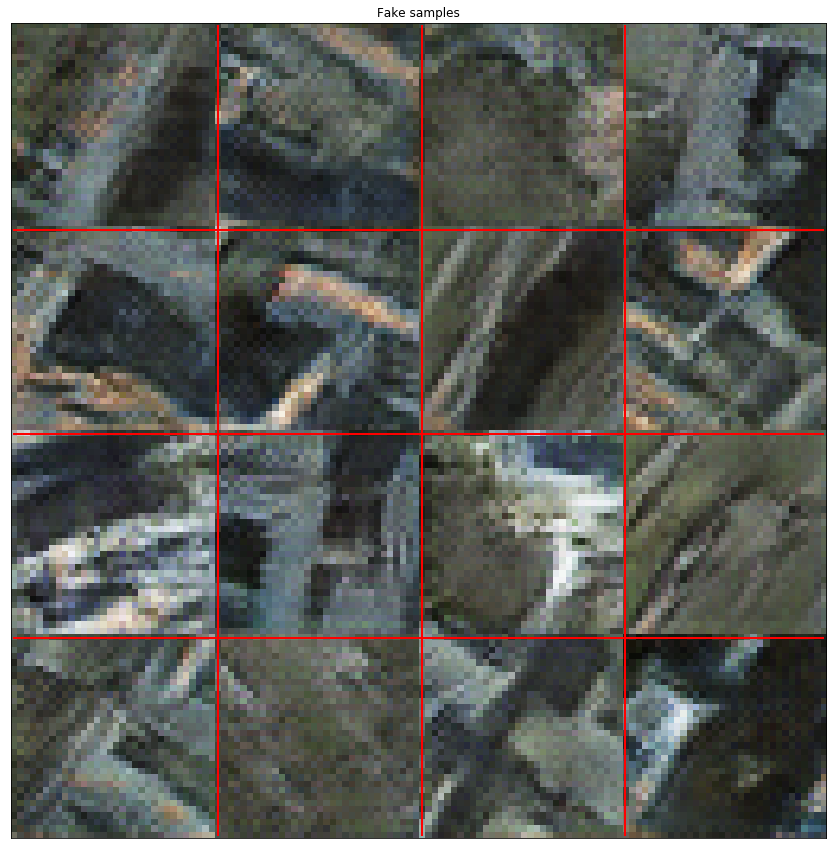

In [14]:
plt.figure(figsize=(15,15))
plot.draw_images(gen_sample,nx=4,ny=4);
plt.title("Fake samples");